In [9]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets,models,transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from scripts.helper import *
from  scripts.forward import Urban100,shiftVariantBlur


In [10]:
def get_img_strip(tensr):
    # shape: [bs,1,h,w]
    bs, _ , h, w = tensr.shape
    tensr2np = (tensr.cpu().detach().numpy().clip(0,1)*255).astype(np.uint8)    
    canvas = np.ones((h, w*bs), dtype = np.uint8)
    for i in range(tensr.shape[0]):
        patch_to_paste = tensr2np[i, 0, :, :]
        canvas[:, i*w: (i+1)*w] = patch_to_paste
    return canvas

torch.Size([4, 1, 512, 512])


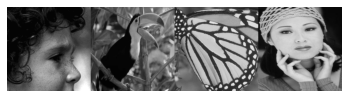

In [11]:
transform = transforms.Compose([
    #transforms.Grayscale(1),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    ])

urban_data = Urban100(root_dir="data/SRBenchmarks/benchmark/Set5/HR",transform=transform)
torch.manual_seed(1)
train_loader = DataLoader(urban_data, batch_size=4, shuffle=True)

images,imgs_noisy,file_name = next(iter(train_loader))
im_orig = get_img_strip(imgs_noisy)

# Print the images
plt.figure(0)
plt.axis("off")
plt.imshow(im_orig,cmap='gray')


print(images.size())

In [12]:
device = torch.device('cuda')
torch.cuda.empty_cache()
psf_info =np.load("psf_info.npz")
psf_arr = psf_info['psf_arr']
indices  = psf_info['indices']
setup = psf_info['setup']
psf_tensor = torch.from_numpy(psf_arr).unsqueeze(1)
#psf_tensor = psf_tensor.expand(psf_tensor.size(0),psf_tensor.size(1)*81,psf_tensor.size(2),psf_tensor.size(3))
print(psf_tensor.size())
#indices = np.load("indices.npy")
step_size = setup[0]//2
images =  F.pad(images,(step_size,step_size,step_size,step_size),"constant",0)
print("Input Image",images.size())
window_arr = []


for n in range(len(psf_arr)):  
    windows = np.zeros(images.shape[2:],float)
    ind = indices[n]
    windows[ind[0]:ind[1],ind[2]:ind[3]] = bartlett(setup[0])
    window_arr.append(windows) 
windows = torch.from_numpy(np.array(window_arr))


img = images.expand(images.shape[0],len(psf_arr),images.shape[2],images.shape[3])
windows = windows.expand(img.shape)
print("Window",windows.size())


img_patches = img*windows
print("Input Image",img_patches.size())

output = F.conv2d(img_patches.to(device),psf_tensor.to(device),groups =psf_tensor.size(0))
output = torch.sum(output,dim=1,keepdim=True)
out = output.detach().cpu().numpy()
print(out.shape)


torch.Size([324, 1, 63, 63])
Input Image torch.Size([4, 1, 574, 574])
Window torch.Size([4, 324, 574, 574])
Input Image torch.Size([4, 324, 574, 574])
(4, 1, 512, 512)


(512, 512)


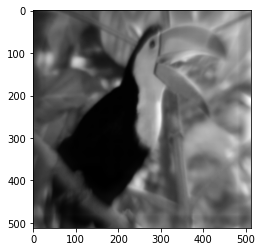

In [15]:
im = out[1,0,:,:]
print(im.shape)
plt.imshow(im,cmap= 'gray')
#out = F.conv2d(images,)
 
